**Problem 8.2** For a deterministic optimization problem of your choice, implement the consensus+innovation, EXTRA and gradient-tracking algorithms and show that distributed gradient descent exhibits a bias, while EXTRA and gradient-tracking converge exactly. How do these findings change with the choice of the step-size $\mu$?


**Solution.** We generate quadratic problems in a manner similar to **Problem 1.1** to demonstrate the benefit of employing bias-corrected algorithms. An advantage of quadratic problems is that we will be possible to compute exact solutions in closed form. This simplifies the problem of evaluating the error.

We generate local data sets $\{ h_{k, n}, \gamma_{k, n} \}_{n=1}^N$ following the statistical model of Example 1.4. To exacerbate the local heterogeneity in the data sets, we use variable local models $w_k$. We begin by importing some standard packages which will be useful throughout this exercise:

In [137]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)

We begin by setting the variance parameters $\sigma_w^2, \sigma_h^2, \sigma_v^2$, network size $K$, sample size $N$ and dimension $M$. Then generate a realization of the weight vector $w$ by sampling once from the normal distribution $\mathcal{N}(0, \sigma_w^2 I_M)$. For each agent $k$, we sample $N$ times from $\mathcal{N}(0, \sigma_h^2 I_M)$ to generate $\{ h_{k, n} \}_{n=1}^N$, and $N$ times from $\mathcal{N}(0, \sigma_v^2)$ to generate $\{ v_{k, n} \}_{n=1}^N$. $\{ \gamma_{k, n} \}_{n=1}^N$ are then generated according to the linear model (1.28). We store data sets in matrices for compact coding.

In [138]:
sigma_h_squared = 1
sigma_v_squared = 0.01
sigma_w_squared = 0

M = 2
K = 10

w_base = np.ones(M)
w = np.random.multivariate_normal(w_base, np.square(sigma_w_squared)*np.eye(M), K).T
w_star = np.mean(w, 1)


Now, we generate a graph using the structure of Problem 7.2.

In [139]:
p_edge = 0.1

lambda_2 = 1
while lambda_2 > 0.99999999:
    C = np.eye(K)
    for k in range(K):
        for l in range(k+1, K):
            connected = np.random.binomial(1, p_edge)
            if connected == 1:
                C[l, k] = 1
                C[k, l] = 1

    n = C@np.ones((K,))

    A = np.zeros((K, K))
    for k in range(K):
        for l in range(k+1, K):
            if C[k, l] == 1:
                A[k, l] = np.true_divide(1, np.max([n[k], n[l]]))
                A[l, k] = A[k, l]

    degrees = A@np.ones((K,))
    for k in range(K):
        A[k, k] = 1 - degrees[k]

    eigs = np.linalg.eigvalsh(A)
    lambda_2 = eigs[-2]
print(lambda_2)


0.9451725804852645


We are not ready to implement the distributed gradient descent, EXTRA and NEXT algorithm.

In [140]:
iterations = 500
experiments = 10
mu = 0.75

w_dgd = np.zeros((M, K, iterations, experiments))
w_dif = np.zeros((M, K, iterations, experiments))
psi_dif = np.zeros((M, K, iterations, experiments))
w_extra = np.zeros((M, K, iterations, experiments))
psi_extra = np.zeros((M, K, iterations, experiments))
phi_extra = np.zeros((M, K, iterations, experiments))
w_tracking = np.zeros((M, K, iterations, experiments))
psi_tracking = np.zeros((M, K, iterations, experiments))

inter_tracking = np.zeros((M, K, iterations, experiments))
g_tracking = np.zeros((M, K, iterations, experiments))

error_dgd = np.zeros((K, iterations, experiments))
error_dif = np.zeros((K, iterations, experiments))
error_extra = np.zeros((K, iterations, experiments))
error_tracking = np.zeros((K, iterations, experiments))

old_gradient = np.zeros((M, K))
new_gradient = np.zeros((M, K))

h = np.zeros((M, K))
v = np.zeros((K, 1))
gamma = np.zeros((K, 1))

for run in range(experiments):
    for k in range(K):
        h[:, k] = np.random.multivariate_normal(np.zeros(M), sigma_h_squared*np.eye(M))
        v[k] = np.random.normal(0, sigma_v_squared)
        gamma[k] = np.matmul(h[:, k].T, w[:, k]) + v[k] 

    # DGD
    for k in range(K):
        for l in range(K):
            w_dgd[:, k, 1, run] += A[l, k] * w_dgd[:, l, 0, run]
    for k in range(K):
        w_dgd[:, k, 1, run] += mu * h[:, k]*(gamma[k] - np.dot(h[:, k], w_dgd[:, k, 0, run]))
    
        error_dgd[k, 0, run] = np.square(np.linalg.norm(w_dgd[:, k, 0, run] - w_star))
        error_dgd[k, 1, run] = np.square(np.linalg.norm(w_dgd[:, k, 1, run] - w_star))
    
    # Diffusion
    for k in range(K):
            psi_dif[:, k, 1, run] = w_dif[:, k, 0, run] + mu * h[:, k]*(gamma[k] - np.dot(h[:, k], w_dif[:, k, 0, run]))
        
    for k in range(K):
        for l in range(K):
            w_dif[:, k, 1, run] += A[l, k] * psi_dif[:, l, 1, run]
        error_dif[k, 0, run] = np.square(np.linalg.norm(w_dif[:, k, 0, run] - w_star))
        error_dif[k, 1, run] = np.square(np.linalg.norm(w_dif[:, k, 1, run] - w_star))

    # EXTRA
    for k in range(K):
            psi_extra[:, k, 1, run] = w_extra[:, k, 0, run] + mu * h[:, k] * (gamma[k] - np.dot(h[:, k], w_extra[:, k, 0, run]))
            phi_extra[:, k, 1, run] = psi_extra[:, k, 1, run] 

    for k in range(K):
        for l in range(K):
            w_extra[:, k, 1, run] += A[l, k] * phi_extra[:, l, 1, run]
        error_extra[k, 0, run] = np.square(np.linalg.norm(w_extra[:, k, 0, run] - w_star))
        error_extra[k, 1, run] = np.square(np.linalg.norm(w_extra[:, k, 1, run] - w_star))

    # AugDGM
    for k in range(K):
        g_tracking[:, k, 0, run] = - h[:, k]*(gamma[k] - np.dot(h[:, k], w_tracking[:, k, 0, run])) 
        psi_tracking[:, k, 1, run] = w_tracking[:, k, 0, run] - mu * g_tracking[:, k, 0, run]
    for k in range(K):
        for l in range(K):
            w_tracking[:, k, 1, run] += A[l, k]*psi_tracking[:, l, 1, run] 
    for k in range(K):
        old_gradient[:, k] = - h[:, k]*(gamma[k] - np.dot(h[:, k], w_tracking[:, k, 0, run]))  
        h[:, k] = np.random.multivariate_normal(np.zeros(M), sigma_h_squared*np.eye(M))
        v[k] = np.random.normal(0, sigma_v_squared)
        gamma[k] = np.matmul(h[:, k].T, w[:, k]) + v[k]  
        new_gradient[:, k] = - h[:, k]*(gamma[k] - np.dot(h[:, k], w_tracking[:, k, 1, run]))  
        inter_tracking[:, k, 1, run] = g_tracking[:, k, 0, run] + new_gradient[:, k] - old_gradient[:, k]
    for k in range(K):
        for l in range(K):
            g_tracking[:, k, 1, run] += A[l, k]*inter_tracking[:, l, 1, run] 

        error_tracking[k, 0, run] = np.square(np.linalg.norm(w_tracking[:, k, 0, run] - w_star))
        error_tracking[k, 1, run] = np.square(np.linalg.norm(w_tracking[:, k, 1, run] - w_star))

    for i in range(2, iterations):
        for k in range(K):
            h[:, k] = np.random.multivariate_normal(np.zeros(M), sigma_h_squared*np.eye(M))
            v[k] = np.random.normal(0, sigma_v_squared)
            gamma[k] = np.matmul(h[:, k].T, w[:, k]) + v[k] 
        # Diffusion
        for k in range(K):
            psi_dif[:, k, i, run] = w_dif[:, k, i-1, run] + mu * h[:, k]*(gamma[k] - np.dot(h[:, k], w_dif[:, k, i-1, run]))
        
        for k in range(K):
            for l in range(K):
                w_dif[:, k, i, run] += A[l, k] * psi_dif[:, l, i, run]
            error_dif[k, i, run] = np.square(np.linalg.norm(w_dif[:, k, i, run] - w_star))

        # DGD
        for k in range(K):
            for l in range(K):
                w_dgd[:, k, i, run] += A[l, k] * w_dgd[:, l, i-1, run]
        for k in range(K):
            w_dgd[:, k, i, run] += mu * h[:, k]*(gamma[k] - np.dot(h[:, k], w_dgd[:, k, i-1, run]))
        
        
            error_dgd[k, i, run] = np.square(np.linalg.norm(w_dgd[:, k, i, run] - w_star))

        # EXTRA
        for k in range(K):
            psi_extra[:, k, i, run] = w_extra[:, k, i-1, run] + mu * h[:, k]*(gamma[k] - np.dot(h[:, k], w_extra[:, k, i-1, run]))
            phi_extra[:, k, i, run] = w_extra[:, k, i-1, run] + psi_extra[:, k, i, run] - psi_extra[:, k, i-1, run]

        for k in range(K):
            for l in range(K):
                w_extra[:, k, i, run] += A[l, k] * phi_extra[:, l, i, run]
            error_extra[k, i, run] = np.square(np.linalg.norm(w_extra[:, k, i, run] - w_star))

        # AugDGM
        for k in range(K):
            psi_tracking[:, k, i, run] = w_tracking[:, k, i-1, run] - mu * g_tracking[:, k, i-1, run]
        for k in range(K):
            for l in range(K):
                w_tracking[:, k, i, run] += A[l, k]*psi_tracking[:, l, i, run] 
        for k in range(K):
            old_gradient[:, k] = new_gradient[:, k]
            new_gradient[:, k] = - h[:, k]*(gamma[k] - np.dot(h[:, k], w_tracking[:, k, i, run]))  
            inter_tracking[:, k, i, run] = g_tracking[:, k, i-1, run] + new_gradient[:, k] - old_gradient[:, k]
        for k in range(K):
            for l in range(K):
                g_tracking[:, k, i, run] += A[l, k]*inter_tracking[:, l, i, run] 

            error_tracking[k, i, run] = np.square(np.linalg.norm(w_tracking[:, k, i, run] - w_star))
        

Finally, we generate the learning curves and plot.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


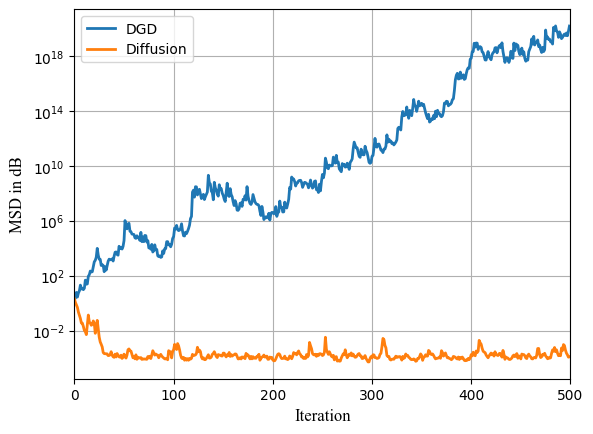

In [141]:
 
learning_curve_ci = np.mean(np.mean(error_dgd, axis=2), axis=0)
learning_curve_dif = np.mean(np.mean(error_dif, axis=2), axis=0)
learning_curve_extra = np.mean(np.mean(error_extra, axis=2), axis=0)
learning_curve_tracking = np.mean(np.mean(error_tracking, axis=2), axis=0)
plt.figure()
plt.semilogy(range(iterations), learning_curve_ci, linewidth=2, label='DGD')
plt.semilogy(range(iterations), learning_curve_dif, linewidth=2, label='Diffusion')
#plt.semilogy(range(iterations), learning_curve_extra, linewidth=2, label='Exact diffusion')
#plt.semilogy(range(iterations), learning_curve_tracking, ':', linewidth=2, label='AugDGM')
plt.xlabel('Iteration',fontsize=12,fontname='times new roman')
plt.ylabel('MSD in dB',fontsize= 12,fontname='times new roman' )
plt.xlim(0,iterations)
plt.legend()
plt.grid()
plt.savefig('../newfigures/chapter-performance/instability.eps', format='eps')
plt.show()

We observe that both EXTRA and gradient-tracking converge exactly, while distributed gradient descent exhibits a bias. Reducing the step-size by a factor of $10$ reduces the bias by a factor of $100$, but is also associated with a reduction in the rate of convergence for all three algorithms.